In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import interp
from scipy.interpolate import UnivariateSpline
from scipy.special import erf
%matplotlib nbagg

In [2]:
def MRIFunc(w,lam,sig,a_cap,z_off): # MRI Function is defined, taking three input values w, lambda and sigma
    lower_depth_nm = -5
    upper_depth_nm = 5
    lower_depth_seg_nm = -5
    upper_depth_seg_nm = 5
    no_spacedvals = 1000
    z_nm = np.linspace(lower_depth_nm,upper_depth_nm,no_spacedvals)# creates sequence of evenly 1000 evenly spaced values from -5 to 5
    z_seg_nm = np.linspace(lower_depth_seg_nm,upper_depth_seg_nm,no_spacedvals)
    z_mri_m = [(i * 1*10**-9)-z_off for i in z_nm] # converts all z values in sequence into metres 
    z_seg_m = [(i * 1*10**-9) for i in z_seg_nm] 
    MRI_int = [] # defines an empty matrix for final mri intensity values
    Seg = []
    for i in z_mri_m: # loops through all the values in z1, inputting them into the analyticl expressino for the MRI
        a = ((1/(2*w))*(1-np.exp(-w/lam))*np.exp(((-i-w)/w)+((sig**2)/(2*w**2)))) # the analytical expression broken down into four parts a,b,c and d
        b = (1 - erf((1/np.sqrt(2))*(((-i-w)/sig)+(sig/w))))
        c = ((1/(2*lam))*np.exp((i/lam)+((sig**2)/(2*lam**2))))
        d = (1 + erf((1/np.sqrt(2))*(((-i-w)/sig)-(sig/lam))))                                                              
        final = (a*b)+(c*d)
        MRI_int.append(final) # the output of the equation is inputted into the empty MRI matrix 
    for i in z_seg_m:
        N_surf = np.exp(a_cap*i)
        Seg.append(N_surf)

    MRI_Ns = np.convolve(MRI_int,Seg)
    return(MRI_Ns)
#print(np.shape(MRI_int))
#print(np.shape(Seg))
#print(np.shape(MRI_Ns))
def EXPFunc(MRI_Ns, A):
    MRI_F = (MRI_Ns/A)*(6.989274999999998e+22) # make sure whatever the area is is +23 not +21
    return(MRI_F)

In [3]:
def MRI_for_fit(z,w,lam,sig,a_ll,zoff):
    MRI_array = MRIFunc(w,lam,sig,a_ll,zoff)
    MRI_arrayN = EXPFunc(MRI_array,np.trapz(MRI_array))
    MRI_output = [MRI_arrayN[int(value)] for value in z]
    return(MRI_output)

In [4]:
from scipy.optimize import curve_fit
df = pd.read_csv(r'\Users\devan\OneDrive\Documents\MasterProject\Morden.csv')
X_data = df.Depth_As.values
Y_data = df.As.values

In [17]:
w_ini = 1.23*10**-9
lam_ini = 0.136*10**-9
sig_ini = 0.4*10**-9
a_cap_ini = 0.043*10**9
z_off_ini = 0
##############
w_lb = 0.9*10**-9
w_ub = 1.3*10**-9
##############
lam_lb = 0.13*10**-9
lam_ub = 0.14*10**-9
##############
sig_lb = 0.1*10**-9
sig_ub = 3*10**-9
##############
a_cap_lb = 0.03*10**9
a_cap_ub = 0.05*10**9
##############
z_off_lb = -5*10**-9
z_off_ub = 5*10**-9
##############
adj_val = 100
##############
xlb = X_data[600]
xub = X_data[1000]
##############
MRI_l = int(xlb*adj_val)
MRI_u = int(xub*adj_val)

<IPython.core.display.Javascript object>


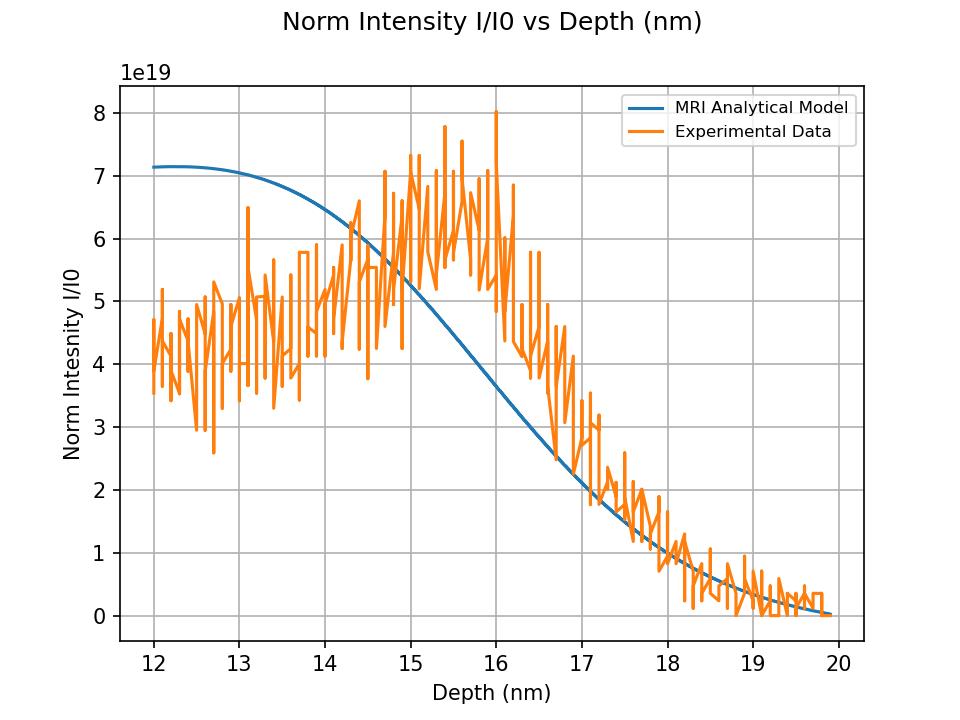

[1.23085127e-09 1.31706647e-10 1.59966250e-09 3.51608715e+07
 1.01775963e-09]


In [18]:
plt.figure()
initial = [w_ini,lam_ini,sig_ini,a_cap_ini,z_off_ini]
popt, pcov= curve_fit(MRI_for_fit, (X_data[600:1000]*adj_val), Y_data[600:1000], initial, bounds = ([w_lb,lam_lb,sig_lb,a_cap_lb,z_off_lb],[w_ub,lam_ub,sig_ub,a_cap_ub,z_off_ub]))
print(popt)
depth_conv_nm = np.linspace(xlb,xub,1999) # a purely aesthetic change
matrix_depth = np.linspace(MRI_l,MRI_u,1999) # this depends on the depth of the final convolved matrix
ax = plt.subplot(111)
ax.plot(depth_conv_nm,MRI_for_fit(np.r_[matrix_depth],popt[0],popt[1],popt[2],popt[3],popt[4]),label = 'MRI Analytical Model')
ax.plot(X_data[600:1000],Y_data[600:1000],label = 'Experimental Data' )
plt.xlabel('Depth (nm)')
plt.ylabel('Norm Intesnity I/I0')
ax.legend(prop={'size': 8})
plt.title("Norm Intensity I/I0 vs Depth (nm)", y = 1.08)
plt.grid()